### American University of Phnom Penh
### ITM 454 001 ~ Natural Language Processing
Instructor: Monyrath BUNTOUN

### Final Project Title: FAQ Chatbot for AUPP Website
**Proposed By:** Senghak Choeun, Y Houk, Channy Prak, Sophea Phin, Laytong Ly  
**Fall 2025 Semester**


### 1. Setup and Imports

In [10]:
import os
import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure NLTK resources
nltk_data = ["punkt", "wordnet", "omw-1.4", "stopwords"]
for res in nltk_data:
    try:
        nltk.data.find(f"tokenizers/{res}") if res == "punkt" else nltk.data.find(f"corpora/{res}")
    except LookupError:
        nltk.download(res)


[nltk_data] Downloading package wordnet to C:\Users\ouk
[nltk_data]     y\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\ouk
[nltk_data]     y\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 2. Load and Explore Dataset

In [15]:

df = pd.read_csv(
    "aupp_faq_dataset.csv", 
    sep=',', 
    on_bad_lines='skip' # <--- FIX: Skip lines that don't match the expected field count
)
df['question'] = df['question'].fillna('').astype(str)
df['answer'] = df['answer'].fillna('').astype(str)
df['category'] = df['category'].fillna('UNKNOWN').astype(str)
print(f"Total questions loaded (after skipping bad lines): {len(df)}")

# Fix tiny labels and merge weak categories
merge_map = {
    "Tuition & Payment": "Tuition Fees",
    "Faculty & Leadership": "University Info",
    "Academic Calendar": "Academic Policies & Regulations"
}

df["category"] = df["category"].replace(merge_map)

# Remove UNKNOWN or empty classes
df = df[df["category"] != "UNKNOWN"]

# Oversample classes to minimum size
from sklearn.utils import resample
min_size = 15 # <--- IMPROVEMENT: Increased from 10 to 15
frames = []

for label in df["category"].unique():
    block = df[df["category"] == label]
    if len(block) < min_size:
        extra = resample(block, replace=True, n_samples=min_size - len(block), random_state=42)
        frames.append(extra)

df = pd.concat([df] + frames, ignore_index=True)
print("Balanced classes:")
print(df["category"].value_counts())

# df = pd.read_csv("aupp_faq_dataset.csv", on_bad_lines='skip')
# df = df[['category', 'question', 'answer']].dropna()
# df['question'] = df['question'].astype(str)
# df['answer'] = df['answer'].astype(str)

# # Clean category names
# df['category'] = df['category'].replace({
#     "Tuition & Payment": "Tuition Fees",
#     "Academic Calendar": "Academic Policies & Regulations"
# })

# print(f"Total FAQs loaded: {len(df)}")
# print("Categories distribution:")
# print(df['category'].value_counts())


Total questions loaded (after skipping bad lines): 60
Balanced classes:
category
Academic Policies & Regulations    28
Admissions                         15
Tuition Fees                       15
Scholarships                       15
Student Life                       15
Name: count, dtype: int64


### 3. Text Preprocessing

In [16]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)          # remove punctuation
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t.isalnum()]
    tokens = [t for t in tokens if t not in stop_words or t in {"not","no"}]  # keep negation
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df['processed_question'] = df['question'].apply(preprocess_text)




### Balance Dataset + Augment Small Classes

### 4. Intent Recognition Model

c:\Users\ouk y\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ouk y\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Accuracy: 0.8888888888888888
Macro F1: 0.8918181818181818
                                 precision    recall  f1-score   support

Academic Policies & Regulations       1.00      0.83      0.91         6
                     Admissions       1.00      1.00      1.00         3
                   Scholarships       1.00      1.00      1.00         3
                   Student Life       1.00      0.67      0.80         3
                   Tuition Fees       0.60      1.00      0.75         3

                       accuracy                           0.89        18
                      macro avg       0.92      0.90      0.89        18
                   weighted avg       0.93      0.89      0.89        18



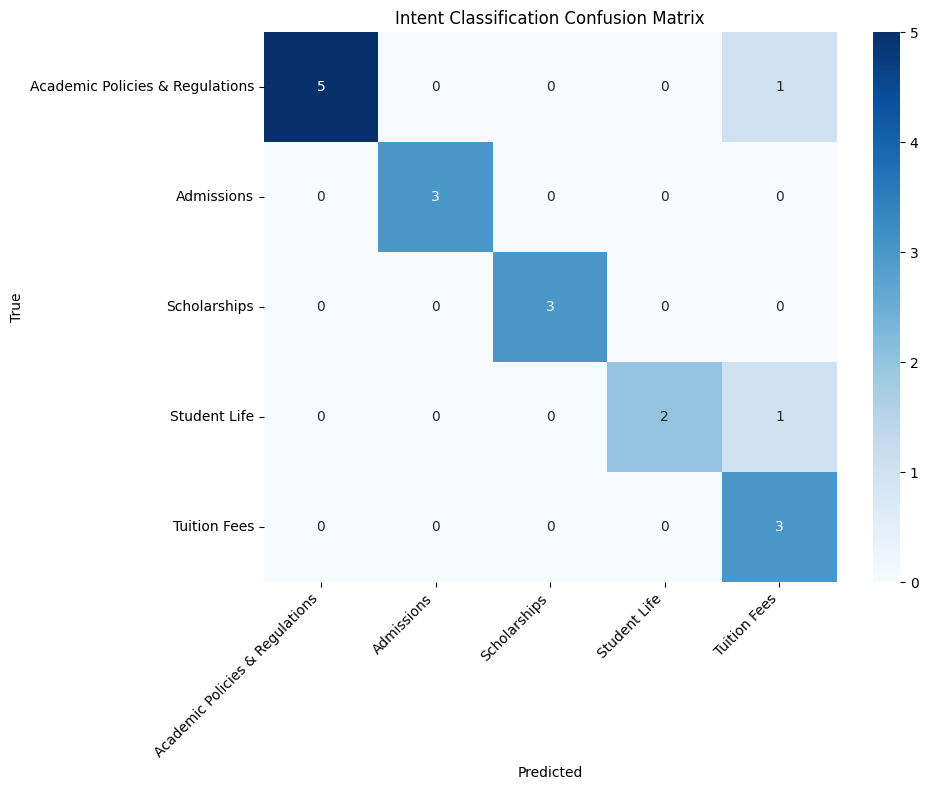

In [20]:
# X = df["processed_question"].astype(str)
# y = df["category"].astype(str)

# # Stratify ensures equal class distribution in train/test splits.
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# intent_pipeline = Pipeline([
#     ("tfidf", TfidfVectorizer(
#         ngram_range=(1, 2),
#         min_df=1,
#         max_df=0.9,
#         max_features=3000
#     )),
#     ("clf", LinearSVC(C=0.5)) #
# ])

# intent_pipeline.fit(X_train, y_train)
# y_pred = intent_pipeline.predict(X_test)

# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
# print(classification_report(y_test, y_pred))
# ...existing code...
X = df["processed_question"].astype(str)
y = df["category"].astype(str)

# Stratify ensures equal class distribution in train/test splits.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

intent_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=1,
        max_df=0.9,
        max_features=3000
    )),
    ("clf", LogisticRegression(
        solver="liblinear",
        multi_class="ovr",
        class_weight="balanced",
        C=1.0,
        max_iter=1000
    ))
])

intent_pipeline.fit(X_train, y_train)
y_pred = intent_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))


# Confusion matrix (plot)
labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Intent Classification Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [18]:
# ...existing code...
# Setup sparse retrieval (used by demonstration)
vectorizer_search = TfidfVectorizer(ngram_range=(1,2), min_df=1)
X_search = vectorizer_search.fit_transform(df['processed_question'].astype(str))

def get_answer(query, threshold=0.25):
    processed_query = preprocess_text(query)
    if not processed_query:
        return "Sorry, I couldn't understand. Please rephrase."
    pred_intent = intent_pipeline.predict([processed_query])[0]
    df_filtered = df[df['category'] == pred_intent]
    if df_filtered.empty:
        return f"Intent '{pred_intent}' recognized but no answer found."
    q_vec = vectorizer_search.transform([processed_query])
    filtered_vecs = X_search[df_filtered.index]
    sims = cosine_similarity(q_vec, filtered_vecs).flatten()
    if sims.size == 0:
        return f"No answer candidates for intent '{pred_intent}'."
    best_idx = int(np.argmax(sims))
    best_score = float(sims[best_idx])
    best_match = df_filtered.iloc[best_idx]
    if best_score < threshold:
        return f"No close answer found (similarity {best_score:.2f}). Please contact Admissions."
    return {
        "intent": pred_intent,
        "match_question": best_match['question'],
        "similarity": best_score,
        "answer": best_match['answer']
    }
# ...existing code...

### 5. Demonstration

In [19]:
test_queries = [
    "How much does a single-degree program cost per semester?",
    "What score do I need on the IELTS for admission?",
    "What kinds of scholarships are available?",
    "Can I pay with ABA mobile app?",
    "tell me about the grading system in AUPP",
    "What if I don't pass the English test?",
    "What is the ID replacement fee?",
]

for q in test_queries:
    resp = get_answer(q)
    print("\n"+"="*50)
    print("Query:", q)
    if isinstance(resp,str):
        print("Response:", resp)
    else:
        print("Intent:", resp['intent'])
        print("Match:", resp['match_question'])
        print("Similarity:", f"{resp['similarity']:.4f}")
        print("Answer:", resp['answer'])





Query: How much does a single-degree program cost per semester?
Intent: Academic Policies & Regulations
Match: What is the maximum course load per semester?
Similarity: 0.4014
Answer: The standard maximum is 17 units; overloads require VPASA approval.

Query: What score do I need on the IELTS for admission?
Intent: Admissions
Match: What is the required IELTS score for direct admission?
Similarity: 0.4898
Answer: An overall band 6.0 and above on the Academic Module of the IELTS (taken within two years of admission) is required for direct admission to Collegiate programs.

Query: What kinds of scholarships are available?
Intent: Scholarships
Match: How do I qualify for a scholarship?
Similarity: 0.3718
Answer: Scholarships are awarded based on academic achievements (Grades A or B on National Examinations), discerned potential, and socioeconomic status of the student's family.

Query: Can I pay with ABA mobile app?
Response: No close answer found (similarity 0.00). Please contact Admiss